In [1]:
import os
from collections import OrderedDict

import torch
import matplotlib.pyplot as plt
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor

[1692694648.856540] [f9dccb8ffe8f:582  :f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


In [2]:
data_path = "/ds2/remote_sensing/ben-ge/ffcv"
num_workers = 4
batch_size = 32

ffcv_modalities = MODALITIES = [
    "multiclass_numer",
    "multiclass_one_h",
    "esa_worldcover",
    "climate_zone",
    "elevation_differ",
    "era_5",
    "season_s1",
    "season_s2",
    "sentinel_1",
    "sentinel_2",
    "glo_30_dem",
    "field_names",
]
used_modalities = ["sentinel_1", "sentinel_2", "glo_30_dem"]

In [3]:
ben_ge_size = "20"
pipelines = OrderedDict()

for mod in ffcv_modalities:
    if mod in used_modalities:
        pipelines[mod] = [ToTensor()]
    else:
        pipelines[mod] = None
        
loader = Loader(
    os.path.join(data_path, f"ben-ge-{ben_ge_size}-train.beton"),
    batch_size=batch_size,
    num_workers=num_workers,
    order=OrderOption.RANDOM,
    pipelines=pipelines,
)

In [95]:
for dem, s1, s2 in loader:
    break

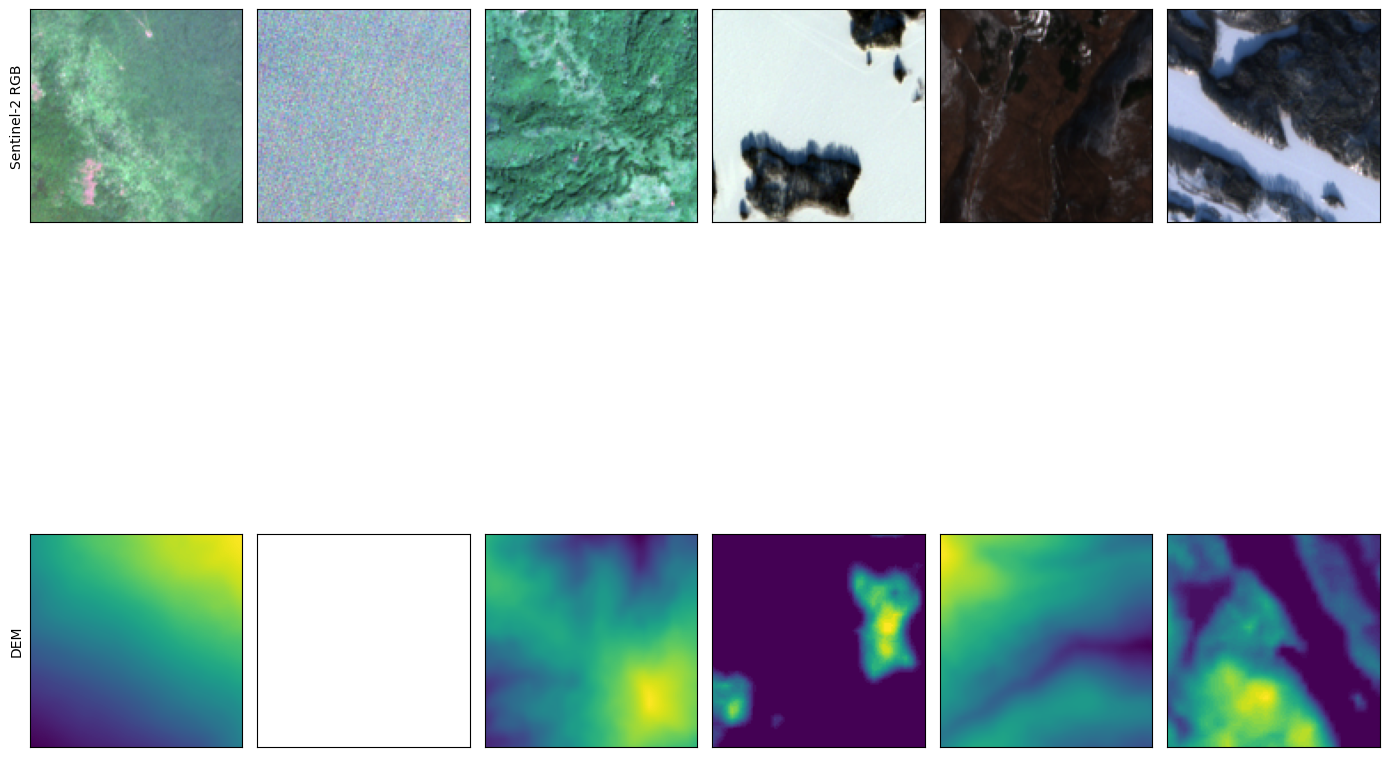

In [100]:
def plot_sentinel_2_and_dem(s1, s2, dem)-> None:
    n_rows = 2 # 7
    fig, axs = plt.subplots(n_rows, 6, figsize=(14,14))
    
    eps = 1e-5
    k = 0
    for col in range(6):
        s2_rgb = torch.moveaxis(s2[k, [3,2,1]], 0, -1)
        axs[0, col].imshow(s2_rgb / s2_rgb.amax(axis=(0,1)))
    
        # s2_re = torch.moveaxis(s2[k, [4,5,6]], 0, -1)
        # axs[1, col].imshow(s2_re / s2_re.amax(axis=(0,1)))
    # 
        # s2_swir_re4 = torch.moveaxis(s2[k, [10,11,8]], 0, -1)
        # axs[2, col].imshow(s2_swir_re4 / s2_swir_re4.amax(axis=(0,1)))
    # 
        # s2_nir = torch.moveaxis(s2[k, [7]], 0, -1)
        # axs[3, col].imshow(s2_nir / s2_nir.amax(axis=(0,1)))
    # 
        # s1_vh = torch.moveaxis(s1[k, 0], 0, -1)
        # axs[4, col].imshow(s1_vh / s1_vh.amax(axis=(0,1)))
    # 
        # s1_vv = torch.moveaxis(s1[k, 1], 0, -1)
        # axs[5, col].imshow(s1_vv / s1_vv.amax(axis=(0,1)))
    # 
        dem_ele = torch.moveaxis(dem[k, 0], 0, -1)
        axs[1, col].imshow(dem_ele / dem_ele.amax(axis=(0,1)))
        
        k += 6
    
    axs[0,0].set_ylabel("Sentinel-2 RGB")#, fontsize=20)
    # axs[1,0].set_ylabel("Sentinel-2 Red Edge")#, fontsize=20)
    # axs[2,0].set_ylabel("Sentinel-2 SWIR + RE4")
    # axs[3,0].set_ylabel("Sentinel-2 NIR")
    # axs[4,0].set_ylabel("Sentinel-1 VH")#, fontsize=20)
    # axs[5,0].set_ylabel("Sentinel-1 VV")#, fontsize=20)
    axs[1,0].set_ylabel("DEM")#, fontsize=20)
    
    for ax in axs.flatten():
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
plot_sentinel_2_and_dem(s1, s2, dem)

In [88]:
import pandas as pd
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image

n_samples = 10
patch_ids = pd.read_csv("/ds2/remote_sensing/ben-ge/ffcv/write_indices/ben-ge-train60-delta.csv").head(n_samples)["patch_id"].to_list()

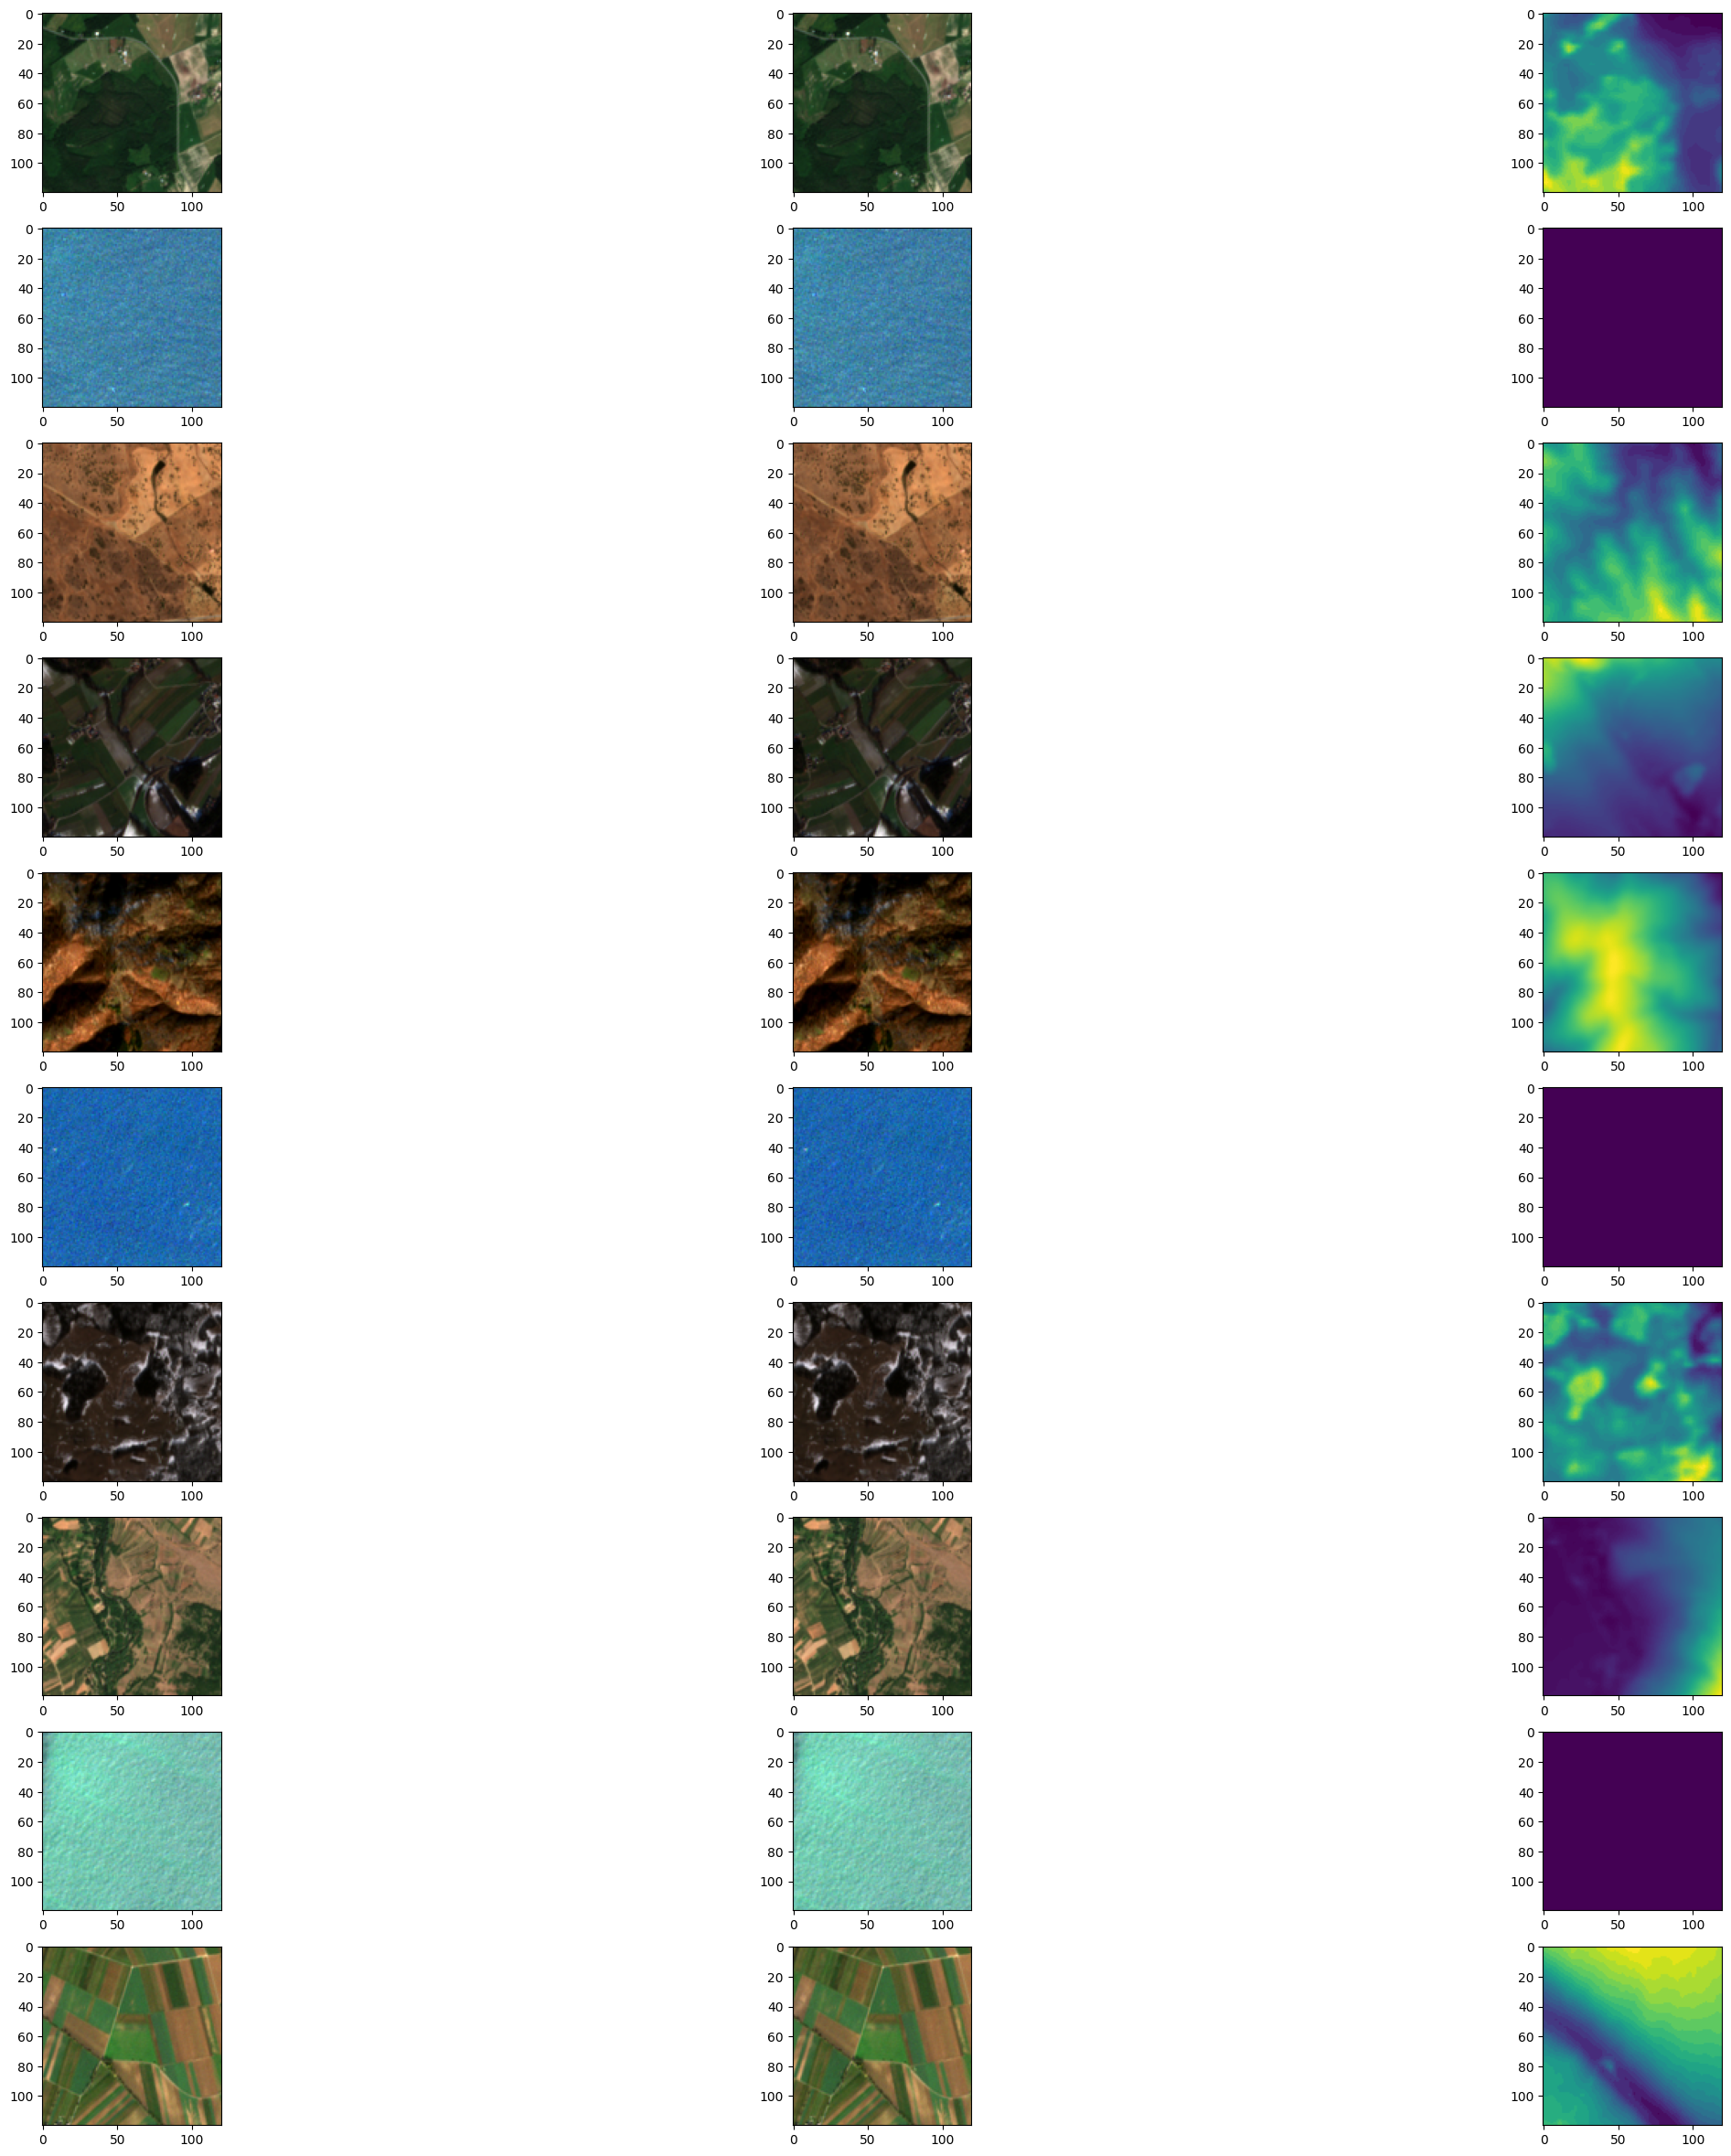

In [94]:
f, axs = plt.subplots(n_samples, 3, figsize=(30, 30))    

for j, patch_id in enumerate(patch_ids):
    dem_path = Path("/ds2/remote_sensing/ben-ge/ben-ge/glo-30_dem/")
    dem_path = dem_path.joinpath(
        dem_path, patch_id + "_dem.tif"
    )
    
    s2_path_root = Path("/ds2/remote_sensing/ben-ge/ben-ge/sentinel-2/")
    s2_path = s2_path_root.joinpath(
        patch_id, patch_id + "_all_bands.npy"
    )
    s2_path_tifs = [s2_path_root.joinpath(
        patch_id, patch_id + f"_B0{i}.tif"
    ) for i in [4, 3, 2]]
    
    def load_rio(path):
        with rio.open(
            path
        ) as image_file:
            img = image_file.read()
        return img
    
    manual_dem = reshape_as_image(load_rio(dem_path))[:, :, 0]
    manual_tif_s2 = reshape_as_image(np.stack([load_rio(p) for p in s2_path_tifs]).squeeze())
    manual_s2 = reshape_as_image(np.load(s2_path))[:, :, [3, 2, 1]]
    
    # plot it
    for i, img in enumerate([manual_s2, manual_tif_s2, manual_dem]):
        axs[j][i].imshow(img / (img.max()+0.00001))

In [101]:
patch_ids

['S2B_MSIL2A_20170709T094029_7_54',
 'S2B_MSIL2A_20170814T100029_84_63',
 'S2A_MSIL2A_20171002T112112_64_39',
 'S2B_MSIL2A_20171219T095409_65_38',
 'S2A_MSIL2A_20171208T093351_66_83',
 'S2A_MSIL2A_20171002T112112_10_40',
 'S2A_MSIL2A_20180318T093031_14_47',
 'S2B_MSIL2A_20170802T092029_30_22',
 'S2A_MSIL2A_20170617T113321_73_83',
 'S2A_MSIL2A_20171104T095201_19_21']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


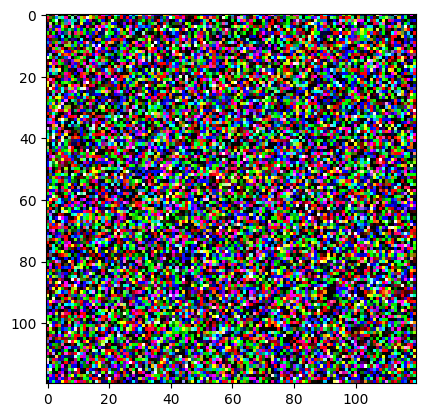

tensor(-4.1221)